# Medicare Fraud Detection

### Data 698: Data Science Research Project - Spring 2019

### Student: Chunhui Zhu

Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2016.csv: https://data.cms.gov/Medicare-Physician-Supplier/Medicare-Provider-Utilization-and-Payment-Data-Phy/utc4-f9xp

LEIE2019.csv: https://oig.hhs.gov/exclusions/exclusions_list.asp

## Continouse from Part IV

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as plt
from matplotlib import pyplot as plt

import pickle
from sklearn.model_selection import train_test_split

import seaborn as sns
%matplotlib inline
from sklearn import preprocessing

from sklearn import metrics

### Obsert from last step "convt2016_pickle"

In [2]:
df_pkl=open("convt_dropcolumns_2016_pickle","rb")
df2016=pickle.load(df_pkl)
df_pkl.close()

In [3]:
df2016.head()

,npi,type,hcpcs_c,line_srvc_cnt,bene_day_srvc_cnt,avg_submitted_chrg_amt,city,state,Fraud
1,1003000126,0.0,99217,57.0,57.0,325.157895,3,2,0
2,1003000126,0.0,99219,38.0,38.0,614.000000,3,2,0
3,1003000126,0.0,99220,23.0,23.0,769.347826,3,2,0
4,1003000126,0.0,99221,20.0,20.0,460.000000,3,2,0
5,1003000126,0.0,99222,96.0,96.0,625.000000,3,2,0


## Prepare for Training set and Test set

### Use 2012-2015 as training data set, 2016 as testing data set

In [4]:
#example pickle name df13_pickle
def loaddf (year):
    y=str(year)
    df_pkl=open("convt_dropcolumns_"+str(year)+"_pickle","rb")
    df=pickle.load(df_pkl)
    print("The number of rows in data set " + "convt_dropcolumns_"+str(year)+"_pickle" +" is " + str(len(df)) + ".")
    df_pkl.close()
    
    print("Broke down fraud and non-fraud data set.")
    df_fraud_0 = df[df['Fraud'] == 0]
    df_fraud_1 = df[df['Fraud'] == 1]
    return (df_fraud_0, df_fraud_1)


In [5]:
fraud2016_0, fraud2016_1, =loaddf(2016)
fraud2015_0, fraud2015_1, =loaddf(2015)
fraud2014_0, fraud2014_1, =loaddf(2014)
fraud2013_0, fraud2013_1, =loaddf(2013)
fraud2012_0, fraud2012_1, =loaddf(2012)

The number of rows in data set convt_dropcolumns_2016_pickle is 7776378.
Broke down fraud and non-fraud data set.
The number of rows in data set convt_dropcolumns_2015_pickle is 8817549.
Broke down fraud and non-fraud data set.
The number of rows in data set convt_dropcolumns_2014_pickle is 8725103.
Broke down fraud and non-fraud data set.
The number of rows in data set convt_dropcolumns_2013_pickle is 8700666.
Broke down fraud and non-fraud data set.
The number of rows in data set convt_dropcolumns_2012_pickle is 8608644.
Broke down fraud and non-fraud data set.


In [6]:
fraud2012to2015_0= [fraud2015_0,fraud2014_0,fraud2013_0,fraud2012_0]
df_fraud2012to2015_0=pd.concat(fraud2012to2015_0)
print(len(df_fraud2012to2015_0))

34814662


In [7]:
fraud2012to2015_1= [fraud2015_1,fraud2014_1,fraud2013_1,fraud2012_1]
df_fraud2012to2015_1=pd.concat(fraud2012to2015_1)
print(len(df_fraud2012to2015_1))

37300


### Exclude 2016 sampling data from 2012-2015 training set

#### Ended in 2015, there is unkonw for the fraud in 2016. I exclusive the 2016 fraud from df_fraud2012to2015_1 data set.

In [9]:
df_fraud2012to2015_1_only=df_fraud2012to2015_1[~df_fraud2012to2015_1.npi.isin(fraud2016_1.npi.unique())]
len(df_fraud2012to2015_1_only)

23182

In [10]:
df_2012to2015=pd.concat([df_fraud2012to2015_0,df_fraud2012to2015_1_only],axis=0)
len(df_2012to2015)

34837844

#### Random sampling 1 million data from 2016 as test data, and exclusive them from training data set

In [11]:
#random sampling 1 Million non-fraud ID from 
test_2016_samples= df2016.sample(1000000, replace=True)

In [12]:
df_2012to2015_only=df_2012to2015[~df_2012to2015.npi.isin(test_2016_samples.npi.unique())]
len(df_2012to2015_only)

12548846

### Ramdom Shuffle all rows using sample()

In [13]:
train_2012to2015_shuffle=df_2012to2015_only.sample( frac = 1 )
test_2016_shuffle=test_2016_samples.sample( frac = 1 )

#### Drop "npi" & "hcpcs_c"

In [14]:
train_2012to2015_shuffle=train_2012to2015_shuffle.drop(['npi','hcpcs_c'],axis=1)
test_2016_shuffle = test_2016_shuffle.drop(['npi', 'hcpcs_c'],axis=1)

Fraud 0: 12525664
Fraud 1: 23182
Proportion: 540.32 : 1


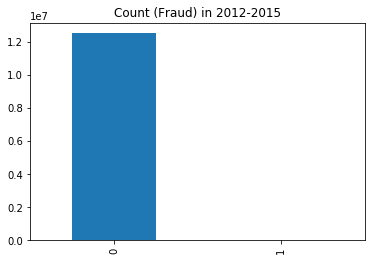

In [15]:
fraud_count = train_2012to2015_shuffle.Fraud.value_counts()
print('Fraud 0:', fraud_count[0])
print('Fraud 1:', fraud_count[1])
print('Proportion:', round(fraud_count[0] / fraud_count[1], 2), ': 1')

fraud_count.plot(kind='bar', title='Count (Fraud) in 2012-2015');

# Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

In [17]:
train_2012to2015_shuffle.head()

,type,line_srvc_cnt,bene_day_srvc_cnt,avg_submitted_chrg_amt,city,state,Fraud
1290106,4.0,49.0,49.0,210.00,2,3,0
5496219,5.0,22.0,22.0,21.00,4,4,0
544419,4.0,846.0,324.0,85.81,4,3,0
3847135,1.0,18.0,18.0,123.00,4,1,0
5522527,1.0,11.0,11.0,205.00,3,2,0


In [18]:
df_x_train_shuffle = train_2012to2015_shuffle.drop(columns=['Fraud'])

In [19]:
df_y_train_shuffle = train_2012to2015_shuffle.Fraud

In [20]:
# fit the model with data
logreg.fit(df_x_train_shuffle,df_y_train_shuffle)

C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
df_x_test_shuffle=test_2016_shuffle.drop(['Fraud'],axis=1)
df_y_test_shuffle=test_2016_shuffle.Fraud

In [22]:
pred_y=logreg.predict(df_x_test_shuffle)

In [23]:
cnf_matrix = metrics.confusion_matrix(df_y_test_shuffle, pred_y)
cnf_matrix

array([[999704,      0],
       [   296,      0]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

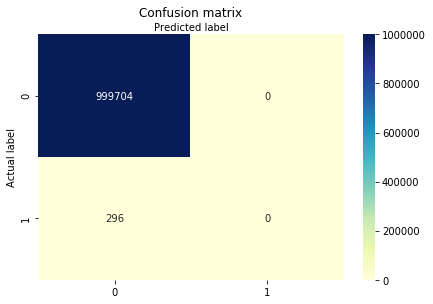

In [24]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [25]:
print("Accuracy:",metrics.accuracy_score(df_y_test_shuffle, pred_y))
print("Precision:",metrics.precision_score(df_y_test_shuffle, pred_y))
print("Recall:",metrics.recall_score(df_y_test_shuffle, pred_y))

Accuracy: 0.999704


C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.0
Recall: 0.0


### ROC Curve

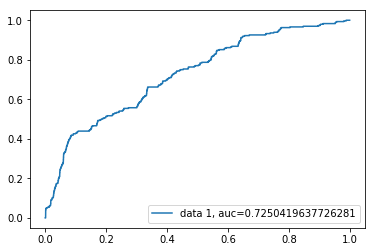

In [26]:
y_pred_proba = logreg.predict_proba(df_x_test_shuffle)[::,1]
fpr, tpr, _ = metrics.roc_curve(df_y_test_shuffle,  y_pred_proba)
auc = metrics.roc_auc_score(df_y_test_shuffle, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Imbalanced-learn module - Over Sampling SMOTE (ratio =1.0)

In [27]:
from imblearn.over_sampling import SMOTE

In [28]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_sm, y_train_sm = sm.fit_sample(df_x_test_shuffle,df_y_test_shuffle)

In [29]:
df_y_train_sm_resample=pd.DataFrame(y_train_sm)
df_x_train_sm_resample=pd.DataFrame(x_train_sm)
aftersample_2012to2015=pd.concat([df_x_train_sm_resample, df_y_train_sm_resample],axis=1)

Fraud 0: 999704
Fraud 1: 999704
Proportion: 1.0 : 1


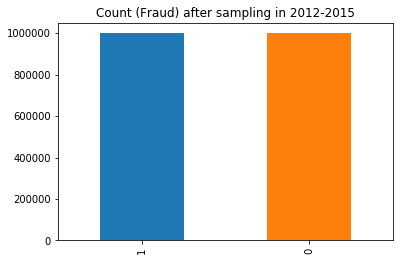

In [30]:
fraud_count_aftersample = aftersample_2012to2015.iloc[:,-1].value_counts()
print('Fraud 0:', fraud_count_aftersample [0])
print('Fraud 1:', fraud_count_aftersample [1])
print('Proportion:', round(fraud_count_aftersample [0] / fraud_count_aftersample [1], 2), ': 1')

fraud_count_aftersample.plot(kind='bar', title='Count (Fraud) after sampling in 2012-2015');

In [31]:
aftersample_2012to2015.columns=['type','line_srvc_cnt','bene_day_srvc_cnt','avg_submitted_chrg_amt','city','state','Fraud']

In [32]:
aftersample_2012to2015.head()

,type,line_srvc_cnt,bene_day_srvc_cnt,avg_submitted_chrg_amt,city,state,Fraud
0,1.0,62.0,54.0,89.000000,4.0,0.0,0
1,4.0,62.0,62.0,325.300000,4.0,0.0,0
2,4.0,12.0,12.0,22.833333,4.0,0.0,0
3,4.0,23.0,23.0,217.000000,3.0,1.0,0
4,2.0,23.0,23.0,90.000000,4.0,0.0,0


## Logistic Regression using Oversampls

In [33]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

In [34]:
# fit the model with data
logreg.fit(df_x_train_sm_resample,df_y_train_sm_resample)

C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
pred_y_oversample=logreg.predict(df_x_test_shuffle)

In [36]:
cnf_matrix = metrics.confusion_matrix(df_y_test_shuffle, pred_y_oversample)
cnf_matrix

array([[725219, 274485],
       [   109,    187]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

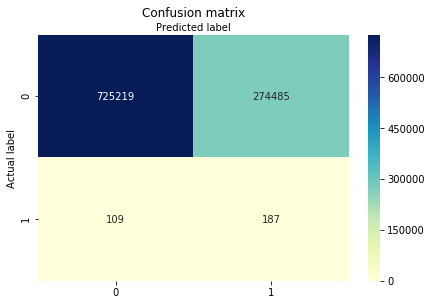

In [37]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [38]:
print("Accuracy:",metrics.accuracy_score(df_y_test_shuffle, pred_y_oversample))
print("Precision:",metrics.precision_score(df_y_test_shuffle, pred_y_oversample))
print("Recall:",metrics.recall_score(df_y_test_shuffle, pred_y_oversample))

Accuracy: 0.725406
Precision: 0.0006808120230675132
Recall: 0.6317567567567568


### ROC Curve for oversample

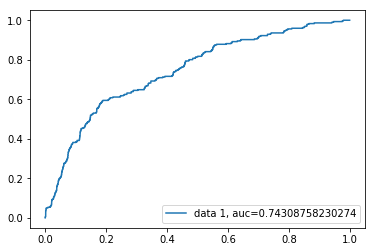

In [39]:
y_pred_proba = logreg.predict_proba(df_x_test_shuffle)[::,1]
fpr, tpr, _ = metrics.roc_curve(df_y_test_shuffle,  y_pred_proba)
auc = metrics.roc_auc_score(df_y_test_shuffle, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Over Sampling SMOTE (ratio =0.8)

In [40]:
sm = SMOTE(random_state=12, ratio = 0.8)
x_train_sm, y_train_sm = sm.fit_sample(df_x_test_shuffle,df_y_test_shuffle)

In [41]:
df_y_train_sm_resample=pd.DataFrame(y_train_sm)
df_x_train_sm_resample=pd.DataFrame(x_train_sm)
aftersample_2012to2015=pd.concat([df_x_train_sm_resample, df_y_train_sm_resample],axis=1)

Fraud 0: 999704
Fraud 1: 799763
Proportion: 1.25 : 1


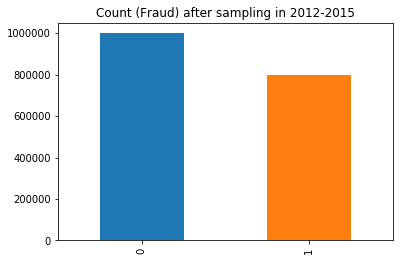

In [42]:
fraud_count_aftersample = aftersample_2012to2015.iloc[:,-1].value_counts()
print('Fraud 0:', fraud_count_aftersample [0])
print('Fraud 1:', fraud_count_aftersample [1])
print('Proportion:', round(fraud_count_aftersample [0] / fraud_count_aftersample [1], 2), ': 1')

fraud_count_aftersample.plot(kind='bar', title='Count (Fraud) after sampling in 2012-2015');

In [43]:
aftersample_2012to2015.columns=['type','line_srvc_cnt','bene_day_srvc_cnt','avg_submitted_chrg_amt','city','state','Fraud']
aftersample_2012to2015.head()

,type,line_srvc_cnt,bene_day_srvc_cnt,avg_submitted_chrg_amt,city,state,Fraud
0,1.0,62.0,54.0,89.000000,4.0,0.0,0
1,4.0,62.0,62.0,325.300000,4.0,0.0,0
2,4.0,12.0,12.0,22.833333,4.0,0.0,0
3,4.0,23.0,23.0,217.000000,3.0,1.0,0
4,2.0,23.0,23.0,90.000000,4.0,0.0,0


In [44]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
logreg.fit(df_x_train_sm_resample,df_y_train_sm_resample)

C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
pred_y_oversample=logreg.predict(df_x_test_shuffle)
cnf_matrix = metrics.confusion_matrix(df_y_test_shuffle, pred_y_oversample)
cnf_matrix

array([[823725, 175979],
       [   130,    166]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

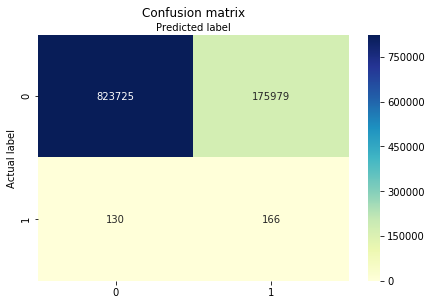

In [46]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [47]:
print("Accuracy:",metrics.accuracy_score(df_y_test_shuffle, pred_y_oversample))
print("Precision:",metrics.precision_score(df_y_test_shuffle, pred_y_oversample))
print("Recall:",metrics.recall_score(df_y_test_shuffle, pred_y_oversample))

Accuracy: 0.823891
Precision: 0.0009424054046382242
Recall: 0.5608108108108109


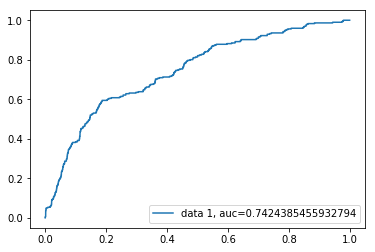

In [48]:
y_pred_proba = logreg.predict_proba(df_x_test_shuffle)[::,1]
fpr, tpr, _ = metrics.roc_curve(df_y_test_shuffle,  y_pred_proba)
auc = metrics.roc_auc_score(df_y_test_shuffle, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Over Sampling SMOTE (ratio =0.5)

In [49]:
sm = SMOTE(random_state=12, ratio = 0.5)
x_train_sm, y_train_sm = sm.fit_sample(df_x_test_shuffle,df_y_test_shuffle)

In [50]:
df_y_train_sm_resample=pd.DataFrame(y_train_sm)
df_x_train_sm_resample=pd.DataFrame(x_train_sm)
aftersample_2012to2015=pd.concat([df_x_train_sm_resample, df_y_train_sm_resample],axis=1)

Fraud 0: 999704
Fraud 1: 499852
Proportion: 2.0 : 1


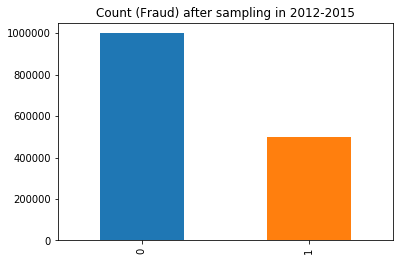

In [51]:
fraud_count_aftersample = aftersample_2012to2015.iloc[:,-1].value_counts()
print('Fraud 0:', fraud_count_aftersample [0])
print('Fraud 1:', fraud_count_aftersample [1])
print('Proportion:', round(fraud_count_aftersample [0] / fraud_count_aftersample [1], 2), ': 1')

fraud_count_aftersample.plot(kind='bar', title='Count (Fraud) after sampling in 2012-2015');

In [52]:
aftersample_2012to2015.columns=['type','line_srvc_cnt','bene_day_srvc_cnt','avg_submitted_chrg_amt','city','state','Fraud']
aftersample_2012to2015.head()

,type,line_srvc_cnt,bene_day_srvc_cnt,avg_submitted_chrg_amt,city,state,Fraud
0,1.0,62.0,54.0,89.000000,4.0,0.0,0
1,4.0,62.0,62.0,325.300000,4.0,0.0,0
2,4.0,12.0,12.0,22.833333,4.0,0.0,0
3,4.0,23.0,23.0,217.000000,3.0,1.0,0
4,2.0,23.0,23.0,90.000000,4.0,0.0,0


In [53]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
logreg.fit(df_x_train_sm_resample,df_y_train_sm_resample)

C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\czhu5\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [54]:
pred_y_oversample=logreg.predict(df_x_test_shuffle)
cnf_matrix = metrics.confusion_matrix(df_y_test_shuffle, pred_y_oversample)
cnf_matrix

array([[877738, 121966],
       [   161,    135]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

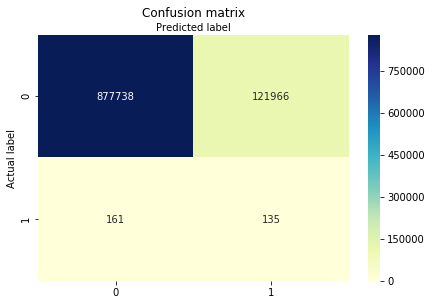

In [55]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [56]:
print("Accuracy:",metrics.accuracy_score(df_y_test_shuffle, pred_y_oversample))
print("Precision:",metrics.precision_score(df_y_test_shuffle, pred_y_oversample))
print("Recall:",metrics.recall_score(df_y_test_shuffle, pred_y_oversample))

Accuracy: 0.877873
Precision: 0.0011056420504336575
Recall: 0.4560810810810811


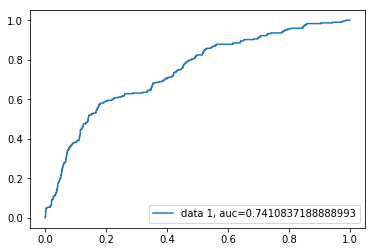

In [57]:
y_pred_proba = logreg.predict_proba(df_x_test_shuffle)[::,1]
fpr, tpr, _ = metrics.roc_curve(df_y_test_shuffle,  y_pred_proba)
auc = metrics.roc_auc_score(df_y_test_shuffle, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Reference

1. LogisticRegression()
https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

2. Resampling strategies for imbalanced datasets
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets